In [1]:
#add project directory to python path
import sys
sys.path.append("..")
from default import PROJECT_DIRECTORY, DATA_DIRECTORY
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

#Compare SHAM Models

In this notebook I explore five SHAM models.  For each of these models, I examine the z=0 galaxy clustering signal and the evolution of the stellar mass.

##Load Simulation

Load the halo catalgue which will be populated using each SHAM model.

In [2]:
from halotools import sim_manager

#load halo catalogue
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol = 0.001,
                                        version_name='custom', halo_finder='Rockstar')

#print out column names of halo catalogue
print(halocat.halo_table.dtype.names)

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')


In [3]:
#define cosmology used in the simulation
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology
print(cosmo)

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.27, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)


In [4]:
#load supplemtary halo catalogue properties
from astropy.table import Table

filepath = '/Volumes/burt/bam_data/'
add_halo_props = Table.read(filepath+"bolshoi_additional_halo_properties.hdf5", path='data')

print(add_halo_props.dtype.names)
print("number of (sub-)haloes: ", len(add_halo_props))

('halo_id', 'halo_mpeak', 'halo_mpeak_scale', 'halo_mpeak_prime', 'halo_mpeak_prime_scale', 'halo_0.1_mpeak_scale', 'halo_0.2_mpeak_scale', 'halo_0.3_mpeak_scale', 'halo_0.4_mpeak_scale', 'halo_0.5_mpeak_scale', 'halo_0.6_mpeak_scale', 'halo_0.7_mpeak_scale', 'halo_0.8_mpeak_scale', 'halo_0.9_mpeak_scale', 'halo_0.1_mpeak_prime_scale', 'halo_0.2_mpeak_prime_scale', 'halo_0.3_mpeak_prime_scale', 'halo_0.4_mpeak_prime_scale', 'halo_0.5_mpeak_prime_scale', 'halo_0.6_mpeak_prime_scale', 'halo_0.7_mpeak_prime_scale', 'halo_0.8_mpeak_prime_scale', 'halo_0.9_mpeak_prime_scale', 'halo_acc_scale_1', 'halo_acc_scale_2', 'halo_acc_scale_3', 'halo_acc_scale_4', 'halo_acc_scale_5', 'halo_acc_scale_6', 'halo_acc_scale_7', 'halo_acc_scale_8', 'halo_acc_scale_9', 'halo_acc_scale_10', 'halo_ejt_scale_1', 'halo_ejt_scale_2', 'halo_ejt_scale_3', 'halo_ejt_scale_4', 'halo_ejt_scale_5', 'halo_ejt_scale_6', 'halo_ejt_scale_7', 'halo_ejt_scale_8', 'halo_ejt_scale_9', 'halo_ejt_scale_10', 'halo_last_acc_scale

In [5]:
#replace with custom properties
halocat.halo_table['halo_mpeak'] = add_halo_props['halo_mpeak_prime']
halocat.halo_table['halo_acc_scale'] = add_halo_props['halo_prime_acc_scale_2']

In [6]:
#clear up some memory
add_halo_props = 0.0

##Define SHAM Models

define some componenets all SHAM models will utilize

In [4]:
from halotools.empirical_models import SubhaloModelFactory

#define stellar mass threshold for each mock
def galaxy_selection_func(table):
    mask = (table['stellar_mass'] >= 10**9.5) & (table['stellar_mass'] < np.inf)
    return mask

#carry over some halo properties to each mock galaxy catalogue
class HaloProps(object):
    """
    class to carry over halo properties to galaxy mock
    """
    def __init__(self,
                 haloprop_keys = ['halo_mpeak','halo_vpeak','halo_acc_scale','halo_half_mass_scale'],
                 **kwargs):
        """
        Parameters
        ----------
        haloprop_keys : list
        """
        
        self._mock_generation_calling_sequence = []
        self._galprop_dtypes_to_allocate = np.dtype([])
        self.list_of_haloprops_needed = haloprop_keys

additional_halo_properties = HaloProps(['halo_mpeak','halo_vpeak',
                                        'halo_half_mass_scale',
                                        'halo_acc_scale'])

#add some derived halo properties used by the M13 and Y13 Models
from cosmo_utils import halo_mass_conversion

m180b = halo_mass_conversion(halocat.halo_table['halo_mpeak'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=180,
                             cosmo=cosmo, wrt_h='background', wrt_new='background')
m200c = halo_mass_conversion(halocat.halo_table['halo_mpeak'],
                             halocat.halo_table['halo_nfw_conc'],
                             delta_h=360, delta_new=200,
                             cosmo=cosmo, wrt_h='background',
                             wrt_new='critical')

#add halo properties for M13 and Y12
halocat.halo_table['halo_mpeak200c'] = m200c
halocat.halo_table['halo_mpeak180b'] = m180b

###Rank Order AM on Mpeak (model #1)

Create mock based on rank order abundance matching using halo mass.

In [5]:
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_mpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1 = SubhaloModelFactory(stellar_mass = mstar_model, 
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)

composite_model_1.param_dict['scatter'] = 0.0

In [6]:
#populate simulation
composite_model_1.populate_mock(halocat = halocat)
mock_1 = composite_model_1.mock.galaxy_table
print(mock_1.dtype.names)

print("number of galaxies in mock: ", len(mock_1))
f_sat = float(np.sum(mock_1['halo_upid']!=-1))/len(mock_1)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  291245
satellite fraction:  0.213383920754


###Rank Order AM on Vpeak (model #2)

In [7]:
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_vpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_2 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)

composite_model_2.param_dict['scatter'] = 0.0

In [8]:
#populate simulation
composite_model_2.populate_mock(halocat = halocat)
mock_2 = composite_model_2.mock.galaxy_table
print(mock_2.dtype.names)

print("number of galaxies in mock: ", len(mock_2))
f_sat = float(np.sum(mock_2['halo_upid']!=-1))/len(mock_2)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  290100
satellite fraction:  0.271313340228


###Moster 2013 Evolving SMHM (model #3)

In [9]:
from SMHM_model_components import MosterSmHm13

#build model
prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_acc_scale'
mstar_model = MosterSmHm13(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 0.701
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_3.param_dict['log_scatter'] =  0.18
composite_model_3.param_dict['m10'] = 11.590
composite_model_3.param_dict['m11'] = 1.195
composite_model_3.param_dict['n10'] = 0.0351
composite_model_3.param_dict['n11'] = -0.0247
composite_model_3.param_dict['beta10'] = 1.376
composite_model_3.param_dict['beta11'] = -0.826
composite_model_3.param_dict['gamma10'] = 0.608
composite_model_3.param_dict['gamma11'] = 0.329

In [21]:
#populate simulation
composite_model_3.populate_mock(halocat = halocat)
mock_3 = composite_model_3.mock.galaxy_table
print(mock_3.dtype.names)
mock_3['stellar_mass'] = mock_3['stellar_mass']*0.9

print("number of galaxies in mock: ", len(mock_3))
f_sat = float(np.sum(mock_3['halo_upid']!=-1))/len(mock_3)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak200c', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  291951
satellite fraction:  0.165031118236


###Yang 2012 Evolving SMHM (model #4)

In [10]:
from SMHM_model_components import Yang12SmHm, Bell_to_Blanton

#build model
prim_haloprop_key =  'halo_mpeak180b'
acc_scale_key='halo_acc_scale'
mstar_model = Yang12SmHm(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 1.0
additional_halo_properties = HaloProps()
mstar_conv = Bell_to_Blanton()
composite_model_4 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        stellar_mass_conversion = mstar_conv,
                                        model_feature_calling_sequence = ('haloprops','stellar_mass','stellar_mass_conversion'))
composite_model_4.param_dict['log_scatter'] =  0.173
composite_model_4.param_dict['c'] =  1.0 #consistent with confidence interval

In [41]:
#populate simulation
composite_model_4.populate_mock(halocat = halocat)
mock_4 = composite_model_4.mock.galaxy_table
print(mock_4.dtype.names)
mock_4['stellar_mass'] = mock_4['stellar_mass']*(0.7)

print("number of galaxies in mock: ", len(mock_4))
f_sat = float(np.sum(mock_4['halo_upid']!=-1))/len(mock_4)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak180b', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  353620
satellite fraction:  0.20491488038


../SMHM_model_components.py:462: UserWarning: Accretion scale is later than the redshift.
  warn(msg)


###Behroozi 2013 Evolving SMHM (model #5)

In [11]:
from SMHM_model_components import BehrooziSmHm13, Moustakas_to_Blanton,  Kauffmann_to_Blanton

#build model
mstar_model = BehrooziSmHm13(redshift=0.0)
additional_halo_properties = HaloProps()
mstar_conv = Kauffmann_to_Blanton()
mstar_conv = Moustakas_to_Blanton()
composite_model_5 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        stellar_mass_conversion = mstar_conv,
                                        model_feature_calling_sequence = ('haloprops','stellar_mass','stellar_mass_conversion'))
composite_model_5.param_dict['log_scatter'] =  0.21

In [17]:
#populate simulation
composite_model_5.populate_mock(halocat = halocat)
mock_5 = composite_model_5.mock.galaxy_table
mock_5['stellar_mass'] =  mock_5['stellar_mass']
print(mock_5.dtype.names)

print("number of galaxies in mock: ", len(mock_5))
f_sat = float(np.sum(mock_5['halo_upid']!=-1))/len(mock_5)
print("satellite fraction: ", f_sat)

../SMHM_model_components.py:260: UserWarning: Accretion scale is later than the redshift.
  warn(msg)
../SMHM_model_components.py:291: RuntimeWarning: overflow encountered in exp
  delta*(((np.log10(1.0+np.exp(x)))**gamma)/(1.0+np.exp(10.0**(-x))))


('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  278527
satellite fraction:  0.185633708761


##The z=0.0 Stellar Mass Function

In [17]:
def stellar_mass_func(mock):
    """
    caclulate stellar mass function
    """
    
    #stellar mass function
    bins = np.arange(9.5,12,0.1)
    bins = 10.0**bins
    bin_centers = (bins[:-1]+bins[1:])/2.0
    counts = np.histogram(mock['stellar_mass'],bins=bins)[0]
    dndm = counts/(halocat.Lbox[0]**3)/0.1

    return dndm, bin_centers, bins

In [24]:
#calculate errors on stellar mass fuction for one mock
Nboot = 25
dndm_2_boot = np.zeros((Nboot,24))
for i in range(0,Nboot):
    print(i)
    composite_model_2.populate_mock(halocat = halocat)
    mock_2 = composite_model_2.mock.galaxy_table
    dndm_2_boot[i,:], bin_centers, bins = stellar_mass_func(mock_2)

dndm_2_err = np.std(dndm_2_boot, axis=0)
dndm_2 = np.mean(dndm_2_boot, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


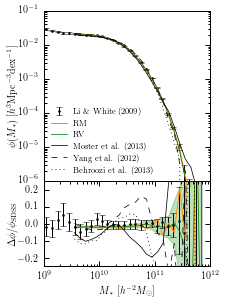

In [32]:
show_error_on_RV = True
smf = 'LiWhite'

if not show_error_on_RV:
    dndm_2, bin_centers, bins = stellar_mass_func(mock_2)

dndm_1, bin_centers, bins = stellar_mass_func(mock_1)
dndm_3, bin_centers, bins = stellar_mass_func(mock_3)
dndm_4, bin_centers, bins = stellar_mass_func(mock_4)
dndm_5, bin_centers, bins = stellar_mass_func(mock_5)

#load sdss results
from lss_observations.stellar_mass_functions import LiWhite_2009_phi, Baldry_2011_phi, Yang_2012_phi
if smf == 'LiWhite':
    sdss_phi = LiWhite_2009_phi()
    sdss_dndm = sdss_phi.data_table['phi']
    sdss_err = sdss_phi.data_table['err']
    sdss_m = sdss_phi.data_table['bin_center']
elif smf == 'Baldry':
    sdss_phi = Baldry_2011_phi()
    sdss_dndm = sdss_phi.data_table['phi']
    sdss_err = sdss_phi.data_table['err']
    sdss_m = sdss_phi.data_table['bin_center']
elif smf == 'Yang':
    sdss_phi = Yang_2012_phi()
    sdss_dndm = sdss_phi.data_table['all']
    sdss_err = sdss_phi.data_table['all_err']
    sdss_m = 10.0**sdss_phi.data_table['bin_center']*0.7

#plot stellar mass function
fig = plt.figure(figsize=(3.3,4.3))

#upper panel
rect = 0.2,0.4,0.7,0.55
ax = fig.add_axes(rect)
p0 = ax.errorbar(sdss_m, sdss_dndm, yerr=sdss_err, fmt='o', color='black', ms=2)
p1, = ax.plot(bin_centers, dndm_1, '-', color='darkorange')
p2, = ax.plot(bin_centers, dndm_2, '-', color='green', lw=0.75)
p3, = ax.plot(bin_centers, dndm_3, '-', color='black', lw=0.75)
p4, = ax.plot(bin_centers, dndm_4, '--', color='black', lw=0.75)
p5, = ax.plot(bin_centers, dndm_5, ':', color='black', lw=0.75)
ax.set_xlim([10**9,10**12])
ax.set_ylim([10**-6,10**-1])
ax.set_yticks([10**-5,10**-4,10**-3,10**-2,10**-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\phi(M_{*})~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$', labelpad=-1)
ax.xaxis.set_visible(False)
plt.legend((p0,p1,p2,p3,p4,p5),
           ("Li \& White (2009)","RM","RV","Moster et al. (2013)",\
            "Yang et al. (2012)","Behroozi et al. (2013)"),\
           loc=3, fontsize=8, frameon=False, numpoints=1)

#lower panel
rect = 0.2,0.125,0.7,0.275
ax = fig.add_axes(rect)
ax.plot(bin_centers, (dndm_1-sdss_phi(bin_centers))/sdss_phi(bin_centers),'-', color='darkorange', lw=1)
ax.plot(bin_centers, (dndm_2-sdss_phi(bin_centers))/sdss_phi(bin_centers),'-', color='green', lw=0.75)
if show_error_on_RV:
    y1 = (dndm_2 + dndm_2_err -sdss_phi(bin_centers))/sdss_phi(bin_centers)
    y2 = (dndm_2 - dndm_2_err -sdss_phi(bin_centers))/sdss_phi(bin_centers)
    ax.fill_between(bin_centers, y1, y2, color='green', alpha=0.25)
ax.plot(bin_centers, (dndm_3-sdss_phi(bin_centers))/sdss_phi(bin_centers),'-', color='black', lw=0.75)
ax.plot(bin_centers, (dndm_4-sdss_phi(bin_centers))/sdss_phi(bin_centers),'--', color='black', lw=0.75)
ax.plot(bin_centers, (dndm_5-sdss_phi(bin_centers))/sdss_phi(bin_centers),':', color='black', lw=0.75)
ax.errorbar(sdss_m,  (sdss_dndm-sdss_phi(sdss_m))/sdss_phi(sdss_m), yerr=(sdss_err)/sdss_phi(sdss_m), fmt='o', color='black', ms=2, lw=1)
ax.set_ylim([-0.25,0.25])
ax.set_yticks([-0.2,-0.1,0.0,0.1,0.2])
ax.set_xlim([10**9,10**12])
ax.set_xscale('log')
ax.set_ylabel(r'$\Delta\phi/\phi_{\rm SDSS}$', labelpad=-2)
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'stellar_mass_function'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##SMHM Relation

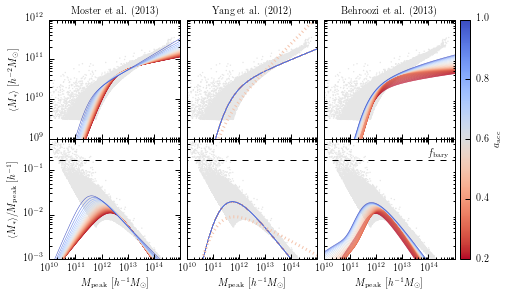

In [16]:
composite_model_4.param_dict['c']=1.0

mhalo_sample = np.logspace(10,15,1000)

redshifts = np.arange(0,4,0.1)[::-1]
scale_factors = 1.0/(1.0+redshifts)

#plot results
from matplotlib import cm
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=False, figsize=(6.95, 4.75))
fig.subplots_adjust(hspace=0, wspace=0.05, left=0.09, right=0.9, bottom=0.2, top=0.9)
 
#top left
ax = axes[0,0]
ax.set_title('Moster et al. (2013)')

ax.scatter(mock_2['halo_mpeak'],mock_2['stellar_mass'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_3.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar, color=color, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**12])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.set_ylabel(r'$\langle M_{*} \rangle ~ [h^{-2}M_{\odot}]$')

#top middle
ax = axes[0,1]
ax.set_title('Yang et al. (2012)')

ax.scatter(mock_2['halo_mpeak'],mock_2['stellar_mass'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar, color=color, lw=0.5)
#show relation at z=1.0
composite_model_4.param_dict['c']=0.0
mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=0.5)
color = color = cm.coolwarm_r((0.5-0.2)/0.8)
ax.plot(mhalo_sample, mean_mstar, ':', color=color, lw=3, alpha=1)
#reset parameter
composite_model_4.param_dict['c']=1.0#0.98
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**12])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14,10.0**15])
ax.get_yaxis().set_ticks([])

#top right
ax = axes[0,2]
ax.set_title('Behroozi et al. (2013)')

ax.scatter(mock_2['halo_mpeak'],mock_2['stellar_mass'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_5.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar, color=color, lw=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**12])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.get_yaxis().set_ticks([])

#bottom left
ax = axes[1,0]

ax.scatter(mock_2['halo_mpeak'],mock_2['stellar_mass']/mock_2['halo_mpeak'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_3.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar/mhalo_sample, color=color, lw=0.5)
ax.plot([10**8,10**16],[0.17,0.17],'--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.5])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.set_ylabel(r'$\langle M_{*} \rangle /M_{\rm peak} ~ [h^{-1}]$')

#bottom middle
ax = axes[1,1]

ax.scatter(mock_2['halo_mpeak'], mock_2['stellar_mass']/mock_2['halo_mpeak'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar/mhalo_sample, color=color, lw=0.5)
#show relation at z=1.0
composite_model_4.param_dict['c']=0.0
mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=0.5)
color = color = cm.coolwarm_r((0.5-0.2)/0.8)
ax.plot(mhalo_sample, mean_mstar/mhalo_sample, ':', color=color, lw=3, alpha=1)
#reset parameter
composite_model_4.param_dict['c']=1.0#0.98
ax.plot([10**8,10**16],[0.17,0.17],'--', color='black')
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.5])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14,10.0**15])
ax.get_yaxis().set_ticks([])

#bottom right
ax = axes[1,2]

ax.scatter(mock_2['halo_mpeak'],mock_2['stellar_mass']/mock_2['halo_mpeak'], c=mock_2['stellar_mass']*0.0 + 0.9,
           lw=0, s=2, vmin=0.0, vmax=1.0, cmap='gray', rasterized=True)

for a in scale_factors:
    color = cm.coolwarm_r((a-0.2)/0.8)
    mean_mstar = composite_model_5.mean_stellar_mass(prim_haloprop = mhalo_sample, halo_acc_scale=a)
    ax.plot(mhalo_sample, mean_mstar/mhalo_sample, color=color, lw=0.5)
ax.plot([10**8,10**16],[0.17,0.17],'--', color='black')
ax.text(10**14,0.2,r'$f_{\rm bary}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.5])
ax.set_xlim([10**10,10**15])
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.get_yaxis().set_ticks([])

#colorbar
p = ax.scatter(scale_factors*0.0,scale_factors*0.0,c=scale_factors, vmin=0.2, vmax=1.0, cmap='coolwarm_r')
cbar_ax = fig.add_axes([0.91, 0.2, 0.02, 0.7]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.set_label(r'$a_{\rm acc}$')
cbar.set_ticks([0.2,0.4,0.6,0.8,1.0])
plt.show()

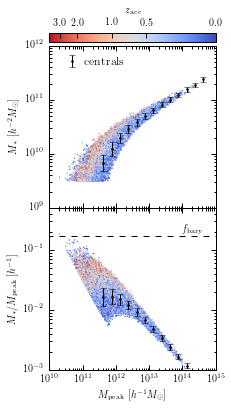

In [30]:
#calculate the SMHM relation for RV mock
from halotools.mock_observables import mean_y_vs_x

subs = (mock_2['halo_upid']!=-1)
hosts = (mock_2['halo_upid']==-1)

bins = np.arange(11.5,15,0.25)
x = np.log10(mock_2['halo_mpeak'][hosts])
y = np.log10(mock_2['stellar_mass'][hosts])
log_bin_centers, log_mean_mstar, log_sigma_mstar = mean_y_vs_x(x,y, bins=bins, error_estimator='variance')

#translate to non-log errors
err_lower = 10**(log_mean_mstar) - 10**(log_mean_mstar-(log_sigma_mstar))
err_upper = 10**(log_mean_mstar+(log_sigma_mstar)) - 10**(log_mean_mstar)
err = np.vstack((err_lower, err_upper))

#plot SMHM relation for mock #2
from matplotlib import cm 
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(3.3, 6.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.9, bottom=0.1, top=0.85)

#top panel
ax = axes[0]
p = ax.scatter(mock_2['halo_mpeak'][subs], mock_2['stellar_mass'][subs], c=mock_2['halo_acc_scale'][subs],
               lw=0, s=2, vmin=0.2, vmax=1.0, cmap='coolwarm_r', rasterized=True)
p2 = ax.errorbar(10.0**log_bin_centers, 10.0**log_mean_mstar, yerr=err, color='black', fmt='o', ms=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**12])
ax.set_xlim([10**10,10**15])
ax.set_ylabel(r'$M_* ~ [h^{-2}M_{\odot}]$')
ax.legend([p2],['centrals'],frameon = False, loc='upper left', numpoints=1, handletextpad=0)

#bottom panel
ax = axes[1]
p = ax.scatter(mock_2['halo_mpeak'][subs],mock_2['stellar_mass'][subs]/mock_2['halo_mpeak'][subs],c=mock_2['halo_acc_scale'][subs],
               lw=0, s=2, vmin=0.2, vmax=1.0, cmap='coolwarm_r', rasterized=True)
p2 = ax.errorbar(10.0**log_bin_centers, (10.0**log_mean_mstar)/(10.0**log_bin_centers), yerr=err/(10.0**log_bin_centers), color='black', fmt='o', ms=2)
ax.plot([10**8,10**16],[0.17,0.17],'--', color='black')
ax.text(10**14,0.2,r'$f_{\rm bary}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.001,0.5])
ax.set_xlim([10**10,10**15])
ax.set_ylabel(r'$M_*/M_{\rm peak} ~ [h^{-1}]$')
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')

#colorbar
cbar_ax = fig.add_axes([0.2, 0.86, 0.7, 0.02]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_label(r'$z_{\rm acc}$', labelpad=-35)
redshifts = np.array([0.0,0.5,1.0,2.0,3.0])
scales = 1.0/(1+redshifts)
cbar.set_ticks(scales)
cbar.set_ticklabels(redshifts)
plt.show()

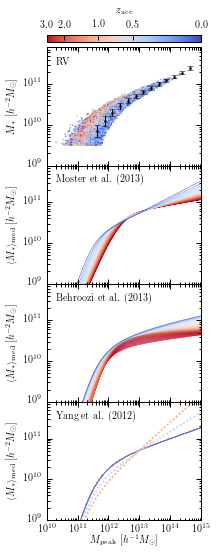

In [14]:
#create a new version of these plots

#SMHM for RV mock
subs = (mock_2['halo_upid']!=-1)
hosts = (mock_2['halo_upid']==-1)

from halotools.mock_observables import mean_y_vs_x
bins = np.arange(11.5,15,0.25)
x = np.log10(mock_2['halo_mpeak'][hosts])
y = np.log10(mock_2['stellar_mass'][hosts])
log_bin_centers, log_mean_mstar, log_sigma_mstar = mean_y_vs_x(x,y, bins=bins, error_estimator='variance')

#translate to non-log errors
err_lower = 10**(log_mean_mstar) - 10**(log_mean_mstar-(log_sigma_mstar))
err_upper = 10**(log_mean_mstar+(log_sigma_mstar)) - 10**(log_mean_mstar)
err = np.vstack((err_lower, err_upper))

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from matplotlib import cm 
fig, axes = plt.subplots(nrows=4,ncols=1, sharex=True, figsize=(3.3, 7.5))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.85, bottom=0.05, top=0.925)

min_redshift = 0
max_redshift = 3
min_a = 1.0/(1.0+max_redshift)
max_a = 1.0/(1.0+min_redshift)

msample = np.logspace(8,16,100)
redshifts = np.arange(0,4,0.1)[::-1]
scale_factors = 1.0/(1.0+redshifts)

#top panel
ax = axes[0]
p = ax.scatter(mock_2['halo_mpeak'][subs], mock_2['stellar_mass'][subs], c=mock_2['halo_acc_scale'][subs],
               lw=0, s=2, vmin=min_a, vmax=max_a, cmap='coolwarm_r', rasterized=True)
p2 = ax.errorbar(10.0**log_bin_centers, 10.0**log_mean_mstar, yerr=err, color='black', fmt='o', ms=2)
#p3, = ax.plot(msample,  mpeak_mstar_model(msample, 0), '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**11.9])
ax.set_xlim([10**10,10**15])
ax.set_ylabel(r'$M_* ~ [h^{-2}M_{\odot}]$')
#ax.legend([p3, p2],['RM','RV centrals'],frameon = False, loc='upper left', numpoints=1, handletextpad=1, fontsize = 8)
#lc = LineCollection(segments_2, cmap='coolwarm_r')
#lc.set_array(c)
#lc.set_linewidth(2)
#ax.add_collection(lc)
#ax.text(1.2*10**11, 0.9*10**11, 'RV satellites', fontsize=8)
ax.text(2*10**10, 3*10**11, 'RV', fontsize=10)

#second panel
ax = axes[1]
#p2 = ax.errorbar(10.0**log_bin_centers, 10.0**log_mean_mstar, yerr=err, color='black', fmt='o', ms=2)
for a in scale_factors:
    color = cm.coolwarm_r((a-min_a)/(max_a-min_a))
    mean_mstar = composite_model_3.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=a)
    ax.plot(msample, mean_mstar, color=color, lw=0.5)
#p3, = ax.plot(msample,  mpeak_mstar_model(msample, 0), '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**11.9])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.set_ylabel(r'$\langle M_{*} \rangle_{\rm med} ~ [h^{-2}M_{\odot}]$')
#ax.legend([p2],['RV centrals'],frameon = False, loc='upper left', numpoints=1, handletextpad=1, fontsize = 8)
#lc = LineCollection(segments_1, cmap='coolwarm_r')
#lc.set_array(c)
#lc.set_linewidth(2)
#ax.add_collection(lc)
#ax.text(1.2*10**11, 1.8*10**11, 'M13', fontsize=8)
ax.text(2*10**10, 3*10**11, 'Moster et al. (2013)', fontsize=10)

#third panel
ax = axes[2]
#p2 = ax.errorbar(10.0**log_bin_centers, 10.0**log_mean_mstar, yerr=err, color='black', fmt='o', ms=2)
for a in scale_factors:
    color = cm.coolwarm_r((a-min_a)/(max_a-min_a))
    mean_mstar = composite_model_5.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=a)
    ax.plot(msample, mean_mstar, color=color, lw=0.5)
#p3, = ax.plot(msample,  mpeak_mstar_model(msample, 0), '-', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**11.9])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14])
ax.set_ylabel(r'$\langle M_{*} \rangle_{\rm med} ~ [h^{-2}M_{\odot}]$')
#ax.legend([p2],['RV centrals'],frameon = False, loc='upper left', numpoints=1, handletextpad=1, fontsize = 8)
#lc = LineCollection(segments_1, cmap='coolwarm_r')
#lc.set_array(c)
#lc.set_linewidth(2)
#ax.add_collection(lc)
#ax.text(1.2*10**11, 1.8*10**11, 'B13', fontsize=8)
ax.text(2*10**10, 3*10**11, 'Behroozi et al. (2013)', fontsize=10)


#bottom panel
ax = axes[3]
#p2 = ax.errorbar(10.0**log_bin_centers, 10.0**log_mean_mstar, yerr=err, color='black', fmt='o', ms=2)
for a in scale_factors:
    color = cm.coolwarm_r((a-min_a)/(max_a-min_a))
    mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=a)
    ax.plot(msample, mean_mstar, color=color, lw=0.5)
#show relation at z=1.0
composite_model_4.param_dict['c']=0.0
scale_factors = [0.67,0.5]
for a in scale_factors:
    color = cm.coolwarm_r((a-min_a)/(max_a-min_a))
    mean_mstar = composite_model_4.mean_stellar_mass(prim_haloprop = msample, halo_acc_scale=a)
    ax.plot(msample, mean_mstar, '--', color=color, lw=2, alpha=1, dashes=(2,2))
#reset parameter
composite_model_4.param_dict['c']=1.0#0.98
#p3 = ax.plot(msample,  mpeak_mstar_model(msample, 0), '-', color='black')
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$', labelpad=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**9,10**11.9])
ax.set_xlim([10**10,10**15])
ax.set_xlabel(r'$M_{\rm peak} ~ [h^{-1}M_{\odot}]$')
ax.set_xticks([10.0**10,10.0**11,10.0**12,10.0**13,10.0**14,10.0**15])
ax.set_ylabel(r'$\langle M_{*} \rangle_{\rm med} ~ [h^{-2}M_{\odot}]$')
#ax.legend([p2],['RV centrals'],frameon = False, loc='upper left', numpoints=1, handletextpad=1, fontsize = 8)
#lc = LineCollection(segments_1, cmap='coolwarm_r')
#lc.set_array(c)
#lc.set_linewidth(2)
#ax.add_collection(lc)
#ax.text(1.2*10**11, 1.8*10**11, 'Y12', fontsize=8)
ax.text(2*10**10, 3*10**11, 'Yang et al. (2012)', fontsize=10)


#colorbar
cbar_ax = fig.add_axes([0.2, 0.935, 0.65, 0.0125]) #xmin, ymin, +dx, +dy
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_label(r'$z_{\rm acc}$', labelpad=-35)
redshifts = np.array([0,0.5,1,2,3])[::-1]
scales = 1.0/(1+redshifts)
cbar.set_ticks(scales)
cbar.set_ticklabels(redshifts)
plt.show()


filepath = PROJECT_DIRECTORY
filename = 'SMHM_comparison'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##z=0 Galaxy Clustering

In [33]:
#set up function to calculate projected correlation function
#in stellar mass bins after placing mock in redshift-space.

from halotools.mock_observables import wp, return_xyz_formatted_array

def calculate_wp(mock, rp_bins,
                 log_mstar_min=10.0, log_mstar_max =10.5,
                 pi_max=40.0, Lbox=250.0):
    """
    Calculate the projected correaltion function
    """
    
    #number of threads to use in wp calculation
    num_threads = 4
    
    #create mask for stellar mass bin
    mask = (mock['stellar_mass']<10.0**log_mstar_max) &\
           (mock['stellar_mass']>10.0**log_mstar_min)
    
    #put galaxy coordinates in mock observables format
    #and apply redshift space distortions
    coords = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'],
                                        velocity = mock['vz'],
                                        velocity_distortion_dimension = 'z',
                                        period = Lbox)
    
    #apply mask for stellar mass bin
    coords = coords[mask]
    
    result = wp(coords,
                rp_bins = rp_bins, pi_max = pi_max,
                period = Lbox,
                do_auto = True, do_cross = False,
                estimator = 'Natural', 
                num_threads = num_threads,
                max_sample_size = int(1e7))
        
    return result

###Calculate Clustering Predicitons for Each Model

In [34]:
#calculate wp for each model in stellar mass bins

#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_1 = np.zeros((3,24))
wp_2 = np.zeros((3,24))
wp_3 = np.zeros((3,24))
wp_4 = np.zeros((3,24))
wp_5 = np.zeros((3,24))

wp_1[0] = calculate_wp(mock_1, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_2[0] = calculate_wp(mock_2, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_3[0] = calculate_wp(mock_3, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_4[0] = calculate_wp(mock_4, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_5[0] = calculate_wp(mock_5, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)

wp_1[1] = calculate_wp(mock_1, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_2[1] = calculate_wp(mock_2, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_3[1] = calculate_wp(mock_3, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_4[1] = calculate_wp(mock_4, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_5[1] = calculate_wp(mock_5, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)

wp_1[2] = calculate_wp(mock_1, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)
wp_2[2] = calculate_wp(mock_2, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)
wp_3[2] = calculate_wp(mock_3, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)
wp_4[2] = calculate_wp(mock_4, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)
wp_5[2] = calculate_wp(mock_5, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)

###calculate jackknife errors on clustering

In [35]:
#calculate jackknife errors on wp for model 2
from halotools.mock_observables import cuboid_subvolume_labels
from halotools.mock_observables import npairs_projected

mock = mock_2
coords = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'],
                                    velocity = mock['vz'],
                                    velocity_distortion_dimension = 'z',
                                    period = halocat.Lbox)

labels, N = cuboid_subvolume_labels(coords, Nsub=[3,3,3], Lbox = halocat.Lbox)

#number of threads to use in wp calculation
num_threads = 4

#create mask for stellar mass bin
mask_a = (mock['stellar_mass']<10.0**10.0) &\
         (mock['stellar_mass']>10.0**9.5)
    
mask_b = (mock['stellar_mass']<10.0**10.5) &\
         (mock['stellar_mass']>10.0**10.0) 
    
mask_c = (mock['stellar_mass']<10.0**11.0) &\
         (mock['stellar_mass']>10.0**10.5)

Npts=10**6
x = np.random.uniform(0, halocat.Lbox[0], Npts)
y = np.random.uniform(0, halocat.Lbox[0], Npts)
z = np.random.uniform(0, halocat.Lbox[0], Npts)
ran_coords = np.vstack((x,y,z)).T

ran_labels, N = cuboid_subvolume_labels(ran_coords, Nsub=[3,3,3], Lbox = halocat.Lbox)

mask_ran = (ran_labels!=1)
ran_coords = ran_coords[mask_ran]

rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0
pi_max=40.0

RR = npairs_projected(ran_coords, ran_coords,
                      rp_bins = rp_bins, pi_max = pi_max,
                      period = halocat.Lbox,
                      num_threads = num_threads)

result_a = np.zeros((N,25))
result_b = np.zeros((N,25))
result_c = np.zeros((N,25))
                    
for i in range(1,N+1):
    print(i)
    mask_1 = (labels!=i)
    
    #apply mask for stellar mass bin
    coords_p = coords[mask_1 & mask_a]
    result_a[i-1] = npairs_projected(coords_p,coords_p,
                    rp_bins = rp_bins, pi_max = pi_max,
                    period = halocat.Lbox,
                    num_threads = num_threads)
    
    coords_p = coords[mask_1 & mask_b]
    result_b[i-1] = npairs_projected(coords_p,coords_p,
                    rp_bins = rp_bins, pi_max = pi_max,
                    period = halocat.Lbox,
                    num_threads = num_threads)
    
    coords_p = coords[mask_1 & mask_c]
    result_c[i-1] = npairs_projected(coords_p,coords_p,
                    rp_bins = rp_bins, pi_max = pi_max,
                    period = halocat.Lbox,
                    num_threads = num_threads)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [36]:
RR = np.diff(RR)
result_a = np.diff(result_a, axis=1)
result_b = np.diff(result_b, axis=1)
result_c = np.diff(result_c, axis=1)

In [37]:
wp_a = 2.0*40.0*((Npts/np.sum(mask_a))**2*(result_a/RR) - 1.0)
wp_b = 2.0*40.0*((Npts/np.sum(mask_b))**2*(result_b/RR) - 1.0)
wp_c = 2.0*40.0*((Npts/np.sum(mask_c))**2*(result_c/RR) - 1.0)

err_a = np.sqrt(np.diag(np.cov(wp_a.T)))
err_b = np.sqrt(np.diag(np.cov(wp_b.T)))
err_c = np.sqrt(np.diag(np.cov(wp_c.T)))

###Load SDSS clustering Measurements

In [38]:
#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

#create intterpolation function
from scipy.interpolate import interp1d
f_w_1 = interp1d(wp_sdss_1[0,:],wp_sdss_1[1,:], fill_value="extrapolate")
f_err_1 = interp1d(wp_sdss_1[0,:],err_1, fill_value="extrapolate")
f_w_2 = interp1d(wp_sdss_2[0,:],wp_sdss_2[1,:], fill_value="extrapolate")
f_err_2 = interp1d(wp_sdss_2[0,:],err_2, fill_value="extrapolate")
f_w_3 = interp1d(wp_sdss_3[0,:],wp_sdss_3[1,:], fill_value="extrapolate")
f_err_3 = interp1d(wp_sdss_3[0,:],err_3, fill_value="extrapolate")

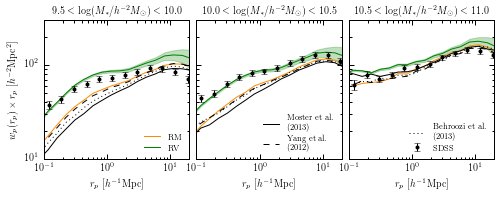

In [39]:
#plot results

use_err=True

fig, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)
    
ax = axes[0]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p)\times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
    
ax = axes[1]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
    
ax = axes[2]
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')

ax = axes[0]
p1, = ax.plot(rp_bin_centers, wp_1[0]*rp_bin_centers, '-', color='darkorange', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_2[0]*rp_bin_centers, '-', color='green', alpha=1)
if use_err==True:
    ax.fill_between(rp_bin_centers, (wp_2[0]+err_a)*rp_bin_centers,(wp_2[0]-err_a)*rp_bin_centers,
                color='green', alpha=0.25)
p3, = ax.plot(rp_bin_centers, wp_3[0]*rp_bin_centers, '-', color='black', alpha=1)
p4, = ax.plot(rp_bin_centers, wp_4[0]*rp_bin_centers, '--', color='black', alpha=1)
p5, = ax.plot(rp_bin_centers, wp_5[0]*rp_bin_centers, ':', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[1]
p1, = ax.plot(rp_bin_centers, wp_1[1]*rp_bin_centers, '-', color='darkorange', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_2[1]*rp_bin_centers, '-', color='green', alpha=1)
if use_err==True:
    ax.fill_between(rp_bin_centers, (wp_2[1]+err_b)*rp_bin_centers,(wp_2[1]-err_b)*rp_bin_centers,
                color='green', alpha=0.25)
p3, = ax.plot(rp_bin_centers, wp_3[1]*rp_bin_centers, '-', color='black', alpha=1)
p4, = ax.plot(rp_bin_centers, wp_4[1]*rp_bin_centers, '--', color='black', alpha=1)
p5, = ax.plot(rp_bin_centers, wp_5[1]*rp_bin_centers, ':', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_2*wp_sdss_2[0,:],
                  fmt='o', color='black', ms=4, mec='none')

ax = axes[2]
p1, = ax.plot(rp_bin_centers, wp_1[2]*rp_bin_centers, '-', color='darkorange', alpha=1)
p2, = ax.plot(rp_bin_centers, wp_2[2]*rp_bin_centers, '-', color='green', alpha=1)
if use_err==True:
    ax.fill_between(rp_bin_centers, (wp_2[2]+err_c)*rp_bin_centers,(wp_2[2]-err_c)*rp_bin_centers,
                color='green', alpha=0.25)
p3, = ax.plot(rp_bin_centers, wp_3[2]*rp_bin_centers, '-', color='black', alpha=1)
p4, = ax.plot(rp_bin_centers, wp_4[2]*rp_bin_centers, '--', color='black', alpha=1)
p5, = ax.plot(rp_bin_centers, wp_5[2]*rp_bin_centers, ':', color='black', alpha=1)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_3*wp_sdss_3[0,:],
                  fmt='o', color='black', ms=4, mec='none')

#add legends
ax = axes[0]
ax.legend((p1,p2),
     ('RM','RV'),
     frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)


ax = axes[1]
ax.legend((p3,p4,p5,p0),
    ('Moster et al.\n (2013)','Yang et al.\n (2012)'),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

ax = axes[2]
ax.legend((p5,p0),
    ('Behroozi et al.\n (2013)', 'SDSS'),
    frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'wp_comparison'
fig.savefig(filepath+filename+'.pdf', dpi=300)

###Satellite Fraction

In [18]:
def f_sat_mstar_dep(mock, Nboot=10):
    """
    satellite fraction as a function of stellar mass
    """

    cens = (mock['halo_upid']==-1)
    sats = (mock['halo_upid']!=-1)

    bins = np.arange(9.5,11.6,0.1)
    bins = 10.0**bins
    bin_centers = (bins[:-1]+bins[1:])/2.0
    
    inds = np.arange(0,len(mock))
    f_sat = np.zeros((Nboot,len(bins)-1))
    for i in range(0,Nboot):
        boot_inds = np.random.choice(inds,len(mock))
        cens = (mock['halo_upid'][boot_inds]==-1)
        sats = (mock['halo_upid'][boot_inds]!=-1)
        n_sat = np.histogram(mock['stellar_mass'][boot_inds][sats], bins=bins)[0]
        n = np.histogram(mock['stellar_mass'],bins=bins)[0]
        f_sat[i,:] = 1.0*n_sat/n
    
    return np.mean(f_sat, axis=0), bin_centers, np.std(f_sat, axis=0)

In [19]:
#calculate errors on stellar mass fuction for one mock
Nboot = 25
f_sat_22_boot = np.zeros((Nboot,20))
for i in range(0,Nboot):
    print(i)
    composite_model_2.populate_mock(halocat = halocat)
    mock_2 = composite_model_2.mock.galaxy_table
    f_sat_22_boot[i,:], bin_centers, err = f_sat_mstar_dep(mock_2, Nboot=1)

err_22 = np.std(f_sat_22_boot, axis=0)
f_sat_22 = np.mean(f_sat_22_boot, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


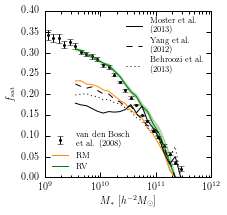

In [22]:
f_sat_11, bin_centers, err_11 = f_sat_mstar_dep(mock_1, Nboot=100)
#f_sat_22, bin_centers, err_22 = f_sat_mstar_dep(mock_2)
f_sat_33, bin_centers, err_33 = f_sat_mstar_dep(mock_3, Nboot=100)
f_sat_44, bin_centers, err_44 = f_sat_mstar_dep(mock_4, Nboot=100)
f_sat_55, bin_centers, err_55 = f_sat_mstar_dep(mock_5, Nboot=100)

f_sat_1 = float(np.sum(mock_1['halo_upid']!=-1))/len(mock_1)
f_sat_2 = float(np.sum(mock_2['halo_upid']!=-1))/len(mock_2)
f_sat_3 = float(np.sum(mock_3['halo_upid']!=-1))/len(mock_3)
f_sat_4 = float(np.sum(mock_4['halo_upid']!=-1))/len(mock_4)
f_sat_5 = float(np.sum(mock_5['halo_upid']!=-1))/len(mock_5)

f_sat_sdss = np.array([31.4,33.0,34.2,33.5,33.4,31.9,32.5,31.5,30.1,\
              29.7,29.1,28.5,26.9,26.5,24.7,22.9,20.9,19.2,\
             17.5,14.9,13.6,11.1,9.7,7.6,5.7,3.5,2.1])/100.0
f_sat_sdss_err = np.array([1.1,1.3,1.2,1.0,1.1,0.8,0.7,0.7,0.5,0.5,0.6,\
                  0.4,0.4,0.4,0.3,0.2,0.3,0.3,0.2,0.2,0.2,0.3,\
                  0.3,0.3,0.3,0.4,0.6])/100.0
m_sdss = 10**np.arange(8.85,11.46,0.1)

    
fig = plt.figure(figsize=(3.3,3.3))
ax = fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
p0 = plt.errorbar(m_sdss,f_sat_sdss,yerr=f_sat_sdss_err,
                  fmt='o', color='black', ms=3, mec='none')
p1, = plt.plot(bin_centers, f_sat_11, '-', color='darkorange')
#plt.plot([2*10**9],[f_sat_1],'o',color='cyan', mec='none', ms=5)
p2, = plt.plot(bin_centers, f_sat_22, '-', color='green')
plt.fill_between(bin_centers, f_sat_22+err_22, f_sat_22-err_22, color='green', alpha=0.25)
#plt.plot([2*10**9],[f_sat_2],'o',color='magenta', mec='none', ms=5)
p3, = plt.plot(bin_centers, f_sat_33, '-', color='black')
#plt.plot([2*10**9],[f_sat_3],'x',color='black', ms=5)
p4, = plt.plot(bin_centers, f_sat_44, '--', color='black')
#plt.plot([2*10**9],[f_sat_4],'s',color='black', mec='none', ms=5)
p5, = plt.plot(bin_centers, f_sat_55, ':',  color='black')
#plt.plot([2*10**9],[f_sat_5],'p',color='black', mec='none', ms=5)
plt.xscale('log')
#plt.yscale('log')
#plt.ylim([0.06,0.5])
plt.xlim([10**9.0,10.0**12.0])
plt.ylim([0,0.4])
plt.xlabel(r'$M_{*}~[h^{-2}M_{\odot}]$')
plt.ylabel(r'$f_{\rm sat}$')

#add legends
first_legend = plt.legend((p0,p1,p2),
     ('van den Bosch\n et al. (2008)','RM','RV'),
     frameon = False, fontsize=8, loc='lower left',
     numpoints=1, handletextpad=1)
ax = plt.gca().add_artist(first_legend)
plt.legend((p3,p4,p5),
     ('Moster et al.\n (2013)','Yang et al.\n (2012)','Behroozi et al.\n (2013)'),
     frameon = False, fontsize=8, loc='upper right',
     numpoints=1, handletextpad=1)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'f_sat_mstar'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##Evolution of Stellar Mass Function

###load halo catalogues

In [12]:
from halotools import sim_manager
from astropy.cosmology import FlatLambdaCDM

#load halo catalogue to populate for mocks
simname = 'bolshoi_250'
redshifts = np.array([-0.0003,0.2463,0.6713,1.0066])
halocat_000 = sim_manager.CachedHaloCatalog(simname = simname, redshift=-0.0003, dz_tol=0.001,
                                            version_name='custom', halo_finder='Rockstar')
halocat_025 = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.2463, dz_tol=0.001,
                                            version_name='custom', halo_finder='Rockstar')
halocat_067 = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.6713, dz_tol=0.001,
                                            version_name='custom', halo_finder='Rockstar')
halocat_100 = sim_manager.CachedHaloCatalog(simname = simname, redshift=1.0066, dz_tol=0.001,
                                            version_name='custom', halo_finder='Rockstar')

cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #bolshoi cosmology

###Build z>0 mocks for RV Model

In [24]:
from SHAM_model_components import ParamSmHm

prim_haloprop_key = 'halo_vpeak'

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.0)
composite_model_2_000 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.25)
composite_model_2_025 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.67)
composite_model_2_067 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=1.0)
composite_model_2_100 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

In [25]:
#populate simulation
composite_model_2_000.populate_mock(halocat = halocat_000)
mock_2_000 = composite_model_2_000.mock.galaxy_table
print(mock_2_000.dtype.names)

composite_model_2_025.populate_mock(halocat = halocat_025)
mock_2_025 = composite_model_2_025.mock.galaxy_table
print(mock_2_025.dtype.names)

composite_model_2_067.populate_mock(halocat = halocat_067)
mock_2_067 = composite_model_2_067.mock.galaxy_table
print(mock_2_067.dtype.names)

composite_model_2_100.populate_mock(halocat = halocat_100)
mock_2_100 = composite_model_2_100.mock.galaxy_table
print(mock_2_100.dtype.names)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak'

###Build z>0 mocks for RM Model

In [26]:
from SHAM_model_components import ParamSmHm

prim_haloprop_key = 'halo_mpeak'

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.0)
composite_model_1_000 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.25)
composite_model_1_025 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=0.67)
composite_model_1_067 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

mstar_model = ParamSmHm(prim_haloprop_key = prim_haloprop_key, log_scatter = 0.0, redshift=1.0)
composite_model_1_100 = SubhaloModelFactory(stellar_mass = mstar_model,
                                            haloprops = additional_halo_properties,
                                            galaxy_selection_func = galaxy_selection_func)

In [27]:
#populate simulation
composite_model_1_000.populate_mock(halocat = halocat_000)
mock_1_000 = composite_model_1_000.mock.galaxy_table
print(mock_1_000.dtype.names)

composite_model_1_025.populate_mock(halocat = halocat_025)
mock_1_025 = composite_model_1_025.mock.galaxy_table
print(mock_1_025.dtype.names)

composite_model_1_067.populate_mock(halocat = halocat_067)
mock_1_067 = composite_model_1_067.mock.galaxy_table
print(mock_1_067.dtype.names)

composite_model_1_100.populate_mock(halocat = halocat_100)
mock_1_100 = composite_model_1_100.mock.galaxy_table
print(mock_1_100.dtype.names)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak'

###Build Mocks for M13 Model for z>0

In [28]:
from SMHM_model_components import MosterSmHm13

#build model
mstar_model_3 = MosterSmHm13(redshift=0.0)
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model_3,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        model_feature_calling_sequence = ('stellar_mass','haloprops'))
composite_model_3.populate_mock(halocat = halocat_000)
mock_3_000 = composite_model_3.mock.galaxy_table

mstar_model_3 = MosterSmHm13(redshift=0.25)
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model_3,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        model_feature_calling_sequence = ('stellar_mass','haloprops'))
composite_model_3.populate_mock(halocat = halocat_025)
mock_3_025 = composite_model_3.mock.galaxy_table

mstar_model_3 = MosterSmHm13(redshift=0.67)
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model_3,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        model_feature_calling_sequence = ('stellar_mass','haloprops'))
composite_model_3.populate_mock(halocat = halocat_067)
mock_3_067 = composite_model_3.mock.galaxy_table

mstar_model_3 = MosterSmHm13(redshift=1.0)
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model_3,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func,
                                        model_feature_calling_sequence = ('stellar_mass','haloprops'))
composite_model_3.populate_mock(halocat = halocat_100)
mock_3_100 = composite_model_3.mock.galaxy_table

In [29]:
mock_3_000['stellar_mass'] = mock_3_000['stellar_mass']*0.9
mock_3_025['stellar_mass'] = mock_3_025['stellar_mass']*0.9
mock_3_067['stellar_mass'] = mock_3_067['stellar_mass']*0.9
mock_3_100['stellar_mass'] = mock_3_100['stellar_mass']*0.9

##Evolution of Stellar Mass Function

In [30]:
def stellar_mass_func(mock, bins=np.logspace(9.5,12.0,26)):
    """
    caclulate stellar mass function
    """
    
    #stellar mass function
    bin_centers = (bins[:-1]+bins[1:])/2.0
    counts = np.histogram(mock['stellar_mass'],bins=bins)[0]
    dndm = counts/(halocat_000.Lbox[0]**3)/0.1

    return dndm, bin_centers

bins = np.arange(9.5,12.0,0.1)
bins = 10.0**bins

#calculate for model #1
dndm_1_a, bin_centers = stellar_mass_func(mock_1_000, bins=bins)
dndm_1_b, bin_centers = stellar_mass_func(mock_1_025, bins=bins)
dndm_1_c, bin_centers = stellar_mass_func(mock_1_067, bins=bins)
dndm_1_d, bin_centers = stellar_mass_func(mock_1_100, bins=bins)

#calculate for model #2
dndm_2_a, bin_centers = stellar_mass_func(mock_2_000, bins=bins)
dndm_2_b, bin_centers = stellar_mass_func(mock_2_025, bins=bins)
dndm_2_c, bin_centers = stellar_mass_func(mock_2_067, bins=bins)
dndm_2_d, bin_centers = stellar_mass_func(mock_2_100, bins=bins)

#calculate for model #3
dndm_3_a, bin_centers = stellar_mass_func(mock_3_000, bins=bins)
dndm_3_b, bin_centers = stellar_mass_func(mock_3_025, bins=bins)
dndm_3_c, bin_centers = stellar_mass_func(mock_3_067, bins=bins)
dndm_3_d, bin_centers = stellar_mass_func(mock_3_100, bins=bins)

In [31]:
#load observational stellar mass functions

from lss_observations.stellar_mass_functions import Tomczak_2014_phi, LiWhite_2009_phi

obs_phi_a = LiWhite_2009_phi(redshift=0.0)
obs_phi_b = Tomczak_2014_phi(redshift=0.25)
obs_phi_c = Tomczak_2014_phi(redshift=0.67)
obs_phi_d = Tomczak_2014_phi(redshift=1.0)

m = obs_phi_b.data_table['bin_center']
phi_b = obs_phi_b.data_table['0.2_0.5']
phi_c = obs_phi_b.data_table['0.5_0.75']
phi_d = obs_phi_b.data_table['1.0_1.25']

phi_b_err = np.vstack((obs_phi_b.data_table['0.2_0.5_minus_err'],
                       obs_phi_b.data_table['0.2_0.5_plus_err']))
phi_c_err = np.vstack((obs_phi_b.data_table['0.5_0.75_minus_err'],
                       obs_phi_b.data_table['0.5_0.75_plus_err']))
phi_d_err = np.vstack((obs_phi_b.data_table['0.75_1.0_minus_err'],
                       obs_phi_b.data_table['0.75_1.0_plus_err']))

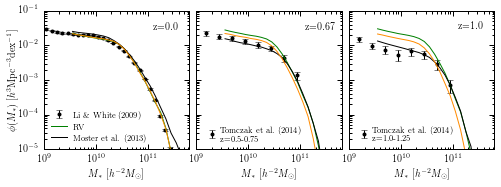

In [33]:
#plot stellar mass function
fig, axes = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(6.95, 2.75))
fig.subplots_adjust(hspace=0, wspace=0.05, left=0.075, right=0.975, bottom=0.2, top=0.9)

ax = axes[0]
ax.text(10.0**11.1, 0.03, 'z=0.0')
p1 = ax.errorbar(obs_phi_a.data_table['bin_center'], obs_phi_a.data_table['phi'],
                 yerr=obs_phi_a.data_table['err'],
                 fmt='o', mec='none', color='black', ms=4)
p2, = ax.plot(bin_centers, dndm_2_a,'-', color='green')
p3, = ax.plot(bin_centers, dndm_3_a,'-', color='black')
p4, = ax.plot(bin_centers, dndm_1_a,'-', color='darkorange')
ax.legend((p1,p2,p3),('Li \& White (2009)','RV','Moster et al. (2013)'),
          fontsize=8, frameon=False, numpoints=1, loc='lower left')

#ax = axes[1]
#ax.text(10.0**11.2, 0.03, 'z=0.25')
#p1 = ax.errorbar(m, phi_b, yerr=phi_b_err,
#                 fmt='o', mec='none', color='black', ms=4)
#ax.plot(bin_centers, dndm_2_b,'-', color='green')
#ax.plot(bin_centers, dndm_3_b,'-', color='black')
#ax.plot(bin_centers, dndm_1_b,'-', color='darkorange')
#ax.legend([p1],['Tomczak et al. (2014)\n z=0.2-0.5'],
#          fontsize=8, frameon=False, numpoints=1, loc='lower left',handletextpad=0)

ax = axes[1]
ax.text(10.0**11.1, 0.03, 'z=0.67')
p1 = ax.errorbar(m, phi_c, yerr=phi_c_err,
                 fmt='o', mec='none', color='black', ms=4)
ax.plot(bin_centers, dndm_2_c,'-', color='green')
ax.plot(bin_centers, dndm_3_c,'-', color='black')
ax.plot(bin_centers, dndm_1_c,'-', color='darkorange')
ax.legend([p1],['Tomczak et al. (2014)\n z=0.5-0.75'],
          fontsize=8, frameon=False, numpoints=1, loc='lower left',handletextpad=0)

ax = axes[2]
ax.text(10.0**11.1, 0.03, 'z=1.0')
p1 = ax.errorbar(m, phi_d, yerr=phi_d_err,
                 fmt='o', mec='none', color='black', ms=4)
ax.plot(bin_centers, dndm_2_d,'-', color='green')
ax.plot(bin_centers, dndm_3_d,'-', color='black')
ax.plot(bin_centers, dndm_1_d,'-', color='darkorange')
ax.legend([p1],['Tomczak et al. (2014)\n z=1.0-1.25'],
          fontsize=8, frameon=False, numpoints=1, loc='lower left',handletextpad=0)

ax = axes[0]
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\phi(M_{*})~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$', labelpad=-1)
ax.set_xlim([10**9,10**11.8])
ax.set_ylim([10**-5,10**-1])
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')
ax = axes[1]
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')
#ax = axes[2]
#ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')
ax = axes[2]
ax.set_xlabel(r'$M_{*} ~[h^{-2}M_{\odot}]$')
plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'stellar_mass_function_evolution_w_rm'
fig.savefig(filepath+filename+'.pdf', dpi=300)

##Stellar Mass Growth Histories

In [20]:
from beyond_age_matching.make_mocks.model_components import PWGH, MAH

v_sample = np.arange(2.0,3.01,0.2)
v_sample = np.arange(2.0,3.01,0.05)

#sample as a function of redshift
z_sample = np.zeros(len(v_sample))

#caclulate average Vpeak histotires of haloes
p = PWGH()

v_sample = 10**v_sample
v_histories, z = p.pwgh(v_sample, z_sample)

#caclulate average Mpeak histotires of haloes
p = MAH()

m_sample = (v_sample/(159.43))**3.0 * 10.0**12
m_histories, z = p.mah(m_sample, z_sample)

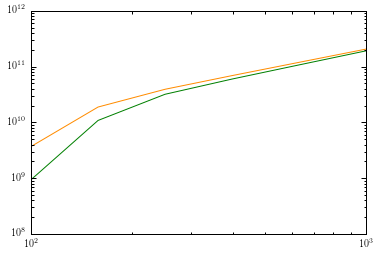

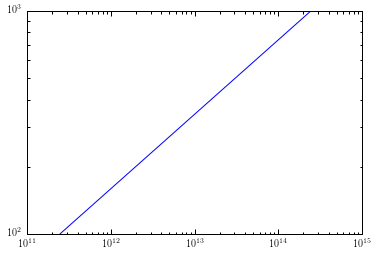

In [17]:
from SHAM_model_components import ParamSmHm
smvp = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.0)
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.0)

plt.figure()
plt.plot(v_sample, smvp.mean_stellar_mass(prim_haloprop=v_sample, scatter=0.0),'-', color='green')
plt.plot(v_sample, smhm.mean_stellar_mass(prim_haloprop=m_sample, scatter=0.0),'-', color='darkorange')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(m_sample,v_sample)
plt.xscale('log')
plt.yscale('log')
plt.show()

0 1.9992380461
1 2.20379371276
2 2.39216171276
3 2.59593337943
4 2.7997500461
5 3.00423571276


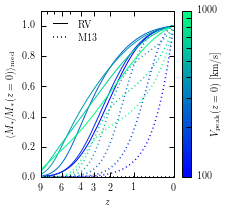

In [18]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=True, figsize=(3.3, 3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
c = np.linspace(0,1,len(v_histories))
from matplotlib import cm
for i, v_history in enumerate(v_histories):
    print(i, v_history[0])
    color = cm.winter(c[i])
    m = smvp.mean_stellar_mass(prim_haloprop=10**v_history)
    p1, = plt.plot(1+z, m/m[0], color=color)
    a = 1.0/(1.0+z)
    composite_model_3.param_dict['c']=0.0
    m = composite_model_3.mean_stellar_mass(prim_haloprop = 10**m_histories[i], halo_acc_scale=a)
    p2, = plt.plot(1+z, m/m[0], ':', color=color, lw=1.5)#, dashes = (1,1))
p1, = plt.plot(1+z, m/m[0]*0.0, color='black')
p2, = plt.plot(1+z, m/m[0]*0.0,':', color='black', lw=1.5)#, dashes = (1,1))
plt.xscale('log')
plt.ylim([0,1.1])
plt.xlim([10,1])
plt.xlabel(r'$z$')
plt.xticks([10,7,5,4,3,2,1])
ax.set_xticklabels(['9','6','4','3','2','1','0'])
plt.ylabel(r'$\langle M_*/M_*(z=0) \rangle_{\rm med}$')
plt.legend((p1,p2), ('RV','M13'), loc='upper left', frameon = False, fontsize=10)
p = plt.scatter(v_sample*0.0,v_sample*0.0,c=np.log10(v_sample),cmap='winter',vmin=2, vmax=3)
cbar = plt.colorbar(p)
#cbar.set_label(r'$\log(V_{\rm peak}(z=0))$')
cbar.set_label(r'$V_{\rm peak}(z=0) ~ [{\rm km/s}]$', labelpad=-5)
cbar.set_ticks(np.log10(np.linspace(100,1000,10)))
cbar.set_ticklabels([100,'','','','','','','','',1000])
plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'mstar_of_z_rm'
fig.savefig(filepath+filename+'.pdf', dpi=300)

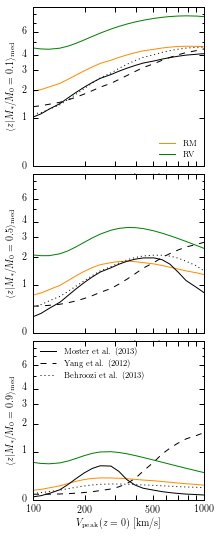

In [23]:
from scipy.interpolate import interp1d

x1 = np.zeros((len(v_histories)))
y1 = np.zeros((3,len(v_histories)))

x2 = np.zeros((len(v_histories)))
y2 = np.zeros((3,len(v_histories)))

x3 = np.zeros((len(v_histories)))
y3 = np.zeros((3,len(v_histories)))

x4 = np.zeros((len(v_histories)))
y4 = np.zeros((3,len(v_histories)))

x5 = np.zeros((len(v_histories)))
y5 = np.zeros((3,len(v_histories)))

for i, v_history in enumerate(v_histories):
    
    m = smhm.mean_stellar_mass(prim_haloprop=10**m_histories[i], scatter=0.0)
    finv = interp1d(m/np.max(m), z)
    x1[i] = 10**v_history[0]
    y1[0,i] = 1+finv(0.1)
    y1[1,i] = 1+finv(0.5)
    y1[2,i] = 1+finv(0.9)
    
    m = smvp.mean_stellar_mass(prim_haloprop=10**v_history, scatter=0.0)
    finv = interp1d(m/np.max(m), z)
    x2[i] = 10**v_history[0]
    y2[0,i] = 1+finv(0.1)
    y2[1,i] = 1+finv(0.5)
    y2[2,i] = 1+finv(0.9)
    
    a = 1.0/(1.0+z)
    
    m = composite_model_3.mean_stellar_mass(prim_haloprop = 10**m_histories[i], halo_acc_scale=a)
    finv = interp1d(m/np.max(m), z)
    x3[i] = 10**v_history[0]
    y3[0,i] = 1+finv(0.1)
    y3[1,i] = 1+finv(0.5)
    y3[2,i] = 1+finv(0.9)
    
    composite_model_4.param_dict['c']=0.0
    m = composite_model_4.mean_stellar_mass(prim_haloprop = 10**m_histories[i], halo_acc_scale=a)
    mask = np.isfinite(m)
    m[mask==False] = 0.0
    mm = np.maximum.accumulate(m[::-1])[::-1]
    finv = interp1d(mm/np.max(m), z)
    x4[i] = 10**v_history[0]
    y4[0,i] = 1+finv(0.1)
    y4[1,i] = 1+finv(0.5)
    y4[2,i] = 1+finv(0.9)
    
    m = composite_model_5.mean_stellar_mass(prim_haloprop = 10**m_histories[i], halo_acc_scale=a)
    finv = interp1d(m/np.max(m), z)
    x5[i] = 10**v_history[0]
    y5[0,i] = 1+finv(0.1)
    y5[1,i] = 1+finv(0.5)
    y5[2,i] = 1+finv(0.9)
    

from matplotlib import cm    

fig, axes = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True,figsize=(3.3, 7.6))
fig.subplots_adjust(hspace=0.05, wspace=0, left=0.18, right=0.9, bottom=0.075, top=0.975)

ax=axes[0]
c = np.linspace(0,1,len(v_histories))
p1, = ax.plot(x1, y1[0,:], '-', color='darkorange')   
p2, = ax.plot(x2, y2[0,:], '-', color='green')   
p3, = ax.plot(x3, y3[0,:], '-', color='black') 
p4, = ax.plot(x4, y4[0,:], '--', color='black') 
p5, = ax.plot(x5, y5[0,:], ':', color='black') 
ax.set_xscale('log')
ax.set_xlim([100,1000])
ax.set_yscale('log')
ax.set_ylim([1,10])
ax.set_ylabel(r'$\langle z | M_*/M_0 = 0.1 \rangle_{\rm med}$')
ax.set_yticks([10,7,5,4,3,2,1])
ax.set_yticklabels(['9','6','4','3','2','1','0'])
ax.set_xticks([100,200,300,400,500,600,700,800,900,1000])
ax.set_xticklabels(['100','200','','','500','','','','','1000'])
ax.set_xlabel(r'$V_{\rm peak}(z=0) ~ [{\rm km/s}]$')

ax=axes[1]
c = np.linspace(0,1,len(v_histories))
p1, = ax.plot(x1, y1[1,:], '-', color='darkorange')   
p2, = ax.plot(x2, y2[1,:], '-', color='green')   
p3, = ax.plot(x3, y3[1,:], '-', color='black') 
p4, = ax.plot(x4, y4[1,:], '--', color='black') 
p5, = ax.plot(x5, y5[1,:], ':', color='black') 
ax.set_xscale('log')
ax.set_xlim([100,1000])
ax.set_yscale('log')
ax.set_ylim([1,10])
ax.set_ylabel(r'$\langle z | M_*/M_0 = 0.5 \rangle_{\rm med}$')
ax.set_yticks([10,7,5,4,3,2,1])
ax.set_yticklabels(['','6','4','3','2','1','0'])
ax.set_xticks([100,200,300,400,500,600,700,800,900,1000])
ax.set_xticklabels(['100','200','','','500','','','','','1000'])
ax.set_xlabel(r'$V_{\rm peak}(z=0) ~ [{\rm km/s}]$')

ax=axes[2]
c = np.linspace(0,1,len(v_histories))
p1, = ax.plot(x1, y1[2,:], '-', color='darkorange')   
p2, = ax.plot(x2, y2[2,:], '-', color='green')   
p3, = ax.plot(x3, y3[2,:], '-', color='black') 
p4, = ax.plot(x4, y4[2,:], '--', color='black') 
p5, = ax.plot(x5, y5[2,:], ':', color='black') 
ax.set_xscale('log')
ax.set_xlim([100,1000])
ax.set_yscale('log')
ax.set_ylim([1,10])
ax.set_ylabel(r'$\langle z | M_*/M_0 = 0.9 \rangle_{\rm med}$')
ax.set_yticks([10,7,5,4,3,2,1])
ax.set_yticklabels(['','6','4','3','2','1','0'])
ax.set_xticks([100,200,300,400,500,600,700,800,900,1000])
ax.set_xticklabels(['100','200','','','500','','','','','1000'])
ax.set_xlabel(r'$V_{\rm peak}(z=0) ~ [{\rm km/s}]$')


#add legends
ax = axes[0]
ax.legend((p1,p2),('RM','RV'), frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)

ax = axes[2]
ax.legend((p3,p4,p5),
     ('Moster et al. (2013)','Yang et al. (2012)','Behroozi et al. (2013)'),
     frameon = False, fontsize=8, loc='upper left', numpoints=1, handletextpad=1)

plt.show()

filepath = PROJECT_DIRECTORY + 'figures/'
filename = 'stellar_mass_zform'
fig.savefig(filepath+filename+'.pdf', dpi=300)

In [180]:
m = composite_model_4.mean_stellar_mass(prim_haloprop = 10**m_histories[i], halo_acc_scale=a)

In [173]:
m = np.nan_to_num(m)

In [176]:
m

array([  1.27666198e+11,   1.28604641e+11,   1.29531801e+11,
         1.30447910e+11,   1.31369115e+11,   1.32295916e+11,
         1.33229545e+11,   1.34170146e+11,   1.35103094e+11,
         1.36042877e+11,   1.36989397e+11,   1.37941958e+11,
         1.38901947e+11,   1.39853098e+11,   1.40825275e+11,
         1.41787989e+11,   1.42756214e+11,   1.43729724e+11,
         1.44692498e+11,   1.45675430e+11,   1.46646938e+11,
         1.47638281e+11,   1.48616872e+11,   1.49598652e+11,
         1.50583077e+11,   1.51571005e+11,   1.52559416e+11,
         1.53549112e+11,   1.54539605e+11,   1.55531789e+11,
         1.56522381e+11,   1.57495335e+11,   1.58488180e+11,
         1.59474809e+11,   1.60440308e+11,   1.61419732e+11,
         1.62395406e+11,   1.63365084e+11,   1.64312193e+11,
         1.65270909e+11,   1.66221462e+11,   1.67163055e+11,
         1.68098373e+11,   1.69021418e+11,   1.69936680e+11,
         1.70839789e+11,   1.71747907e+11,   1.72627902e+11,
         1.73509399e+11,

##Effect of Primary Accretion Definition on Clustering

In [20]:
from SMHM_model_components import MosterSmHm13

#build model
prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_acc_scale_1'
mstar_model = MosterSmHm13(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 1.0#0.8
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_3.param_dict['scatter_model_param1'] =  0.18
composite_model_3.param_dict['m10'] = 11.590
composite_model_3.param_dict['m11'] = 1.195
composite_model_3.param_dict['n10'] = 0.0351
composite_model_3.param_dict['n11'] = -0.0247
composite_model_3.param_dict['beta10'] = 1.376
composite_model_3.param_dict['beta11'] = -0.826
composite_model_3.param_dict['gamma10'] = 0.608
composite_model_3.param_dict['gamma11'] = 0.329

#populate simulation
composite_model_3.populate_mock(halocat = halocat)
mock_3a = composite_model_3.mock.galaxy_table
print(mock_3a.dtype.names)
mock_3a['stellar_mass'] = mock_3a['stellar_mass']*0.9

print("number of galaxies in mock: ", len(mock_3a))
f_sat = float(np.sum(mock_3a['halo_upid']!=-1))/len(mock_3a)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak200c', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_acc_scale_1', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  287225
satellite fraction:  0.16307424493


In [21]:
#build model
prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_last_acc_scale'
mstar_model = MosterSmHm13(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 1.0#0.8
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_3.param_dict['scatter_model_param1'] =  0.18
composite_model_3.param_dict['m10'] = 11.590
composite_model_3.param_dict['m11'] = 1.195
composite_model_3.param_dict['n10'] = 0.0351
composite_model_3.param_dict['n11'] = -0.0247
composite_model_3.param_dict['beta10'] = 1.376
composite_model_3.param_dict['beta11'] = -0.826
composite_model_3.param_dict['gamma10'] = 0.608
composite_model_3.param_dict['gamma11'] = 0.329

#populate simulation
composite_model_3.populate_mock(halocat = halocat)
mock_3b = composite_model_3.mock.galaxy_table
print(mock_3a.dtype.names)
mock_3b['stellar_mass'] = mock_3b['stellar_mass']*0.9

print("number of galaxies in mock: ", len(mock_3b))
f_sat = float(np.sum(mock_3b['halo_upid']!=-1))/len(mock_3b)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak200c', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_acc_scale_1', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  294778
satellite fraction:  0.181241476637


In [22]:
#build model
prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_prime_acc_scale_1'
mstar_model = MosterSmHm13(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 1.0#0.8
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_3.param_dict['scatter_model_param1'] =  0.18
composite_model_3.param_dict['m10'] = 11.590
composite_model_3.param_dict['m11'] = 1.195
composite_model_3.param_dict['n10'] = 0.0351
composite_model_3.param_dict['n11'] = -0.0247
composite_model_3.param_dict['beta10'] = 1.376
composite_model_3.param_dict['beta11'] = -0.826
composite_model_3.param_dict['gamma10'] = 0.608
composite_model_3.param_dict['gamma11'] = 0.329

#populate simulation
composite_model_3.populate_mock(halocat = halocat)
mock_3c = composite_model_3.mock.galaxy_table
print(mock_3c.dtype.names)
mock_3c['stellar_mass'] = mock_3c['stellar_mass']*0.9

print("number of galaxies in mock: ", len(mock_3c))
f_sat = float(np.sum(mock_3c['halo_upid']!=-1))/len(mock_3c)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak200c', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_prime_acc_scale_1', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_half_mass_scale', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  300546
satellite fraction:  0.162104968956


In [23]:
#build model
prim_haloprop_key =  'halo_mpeak200c'
acc_scale_key='halo_prime_acc_scale_2'
mstar_model = MosterSmHm13(redshift=0.0, prim_haloprop_key=prim_haloprop_key, acc_scale_key=acc_scale_key)
mstar_model.littleh = 0.701
mstar_model._m_conv_factor = 1.0#0.8
composite_model_3 = SubhaloModelFactory(stellar_mass = mstar_model,
                                        haloprops = additional_halo_properties,
                                        galaxy_selection_func = galaxy_selection_func)
composite_model_3.param_dict['scatter_model_param1'] =  0.18
composite_model_3.param_dict['m10'] = 11.590
composite_model_3.param_dict['m11'] = 1.195
composite_model_3.param_dict['n10'] = 0.0351
composite_model_3.param_dict['n11'] = -0.0247
composite_model_3.param_dict['beta10'] = 1.376
composite_model_3.param_dict['beta11'] = -0.826
composite_model_3.param_dict['gamma10'] = 0.608
composite_model_3.param_dict['gamma11'] = 0.329

#populate simulation
composite_model_3.populate_mock(halocat = halocat)
mock_3d = composite_model_3.mock.galaxy_table
print(mock_3d.dtype.names)
mock_3d['stellar_mass'] = mock_3d['stellar_mass']*0.9

print("number of galaxies in mock: ", len(mock_3d))
f_sat = float(np.sum(mock_3d['halo_upid']!=-1))/len(mock_3d)
print("satellite fraction: ", f_sat)

('halo_upid', 'halo_hostid', 'halo_mpeak200c', 'halo_mpeak', 'halo_acc_scale', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_vpeak', 'halo_rvir', 'halo_half_mass_scale', 'halo_mvir', 'halo_prime_acc_scale_2', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')
number of galaxies in mock:  301282
satellite fraction:  0.162635006406


In [27]:
#define rp bins
rp_bins = np.logspace(-2.0,1.4,25)
rp_bin_centers = (rp_bins[:-1]+rp_bins[1:])/2.0

#create arrays to store results for each mock
wp_3a = np.zeros((3,24))
wp_3b = np.zeros((3,24))
wp_3c = np.zeros((3,24))
wp_3d = np.zeros((3,24))

wp_3a[0] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_3a[1] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_3a[2] = calculate_wp(mock_3a, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)

wp_3b[0] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_3b[1] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_3b[2] = calculate_wp(mock_3b, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)

wp_3c[0] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_3c[1] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_3c[2] = calculate_wp(mock_3c, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)

wp_3d[0] = calculate_wp(mock_3d, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=9.5, log_mstar_max =10.0)
wp_3d[1] = calculate_wp(mock_3d, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.0, log_mstar_max =10.5)
wp_3d[2] = calculate_wp(mock_3d, rp_bins, pi_max=40.0, Lbox=halocat.Lbox,
                    log_mstar_min=10.5, log_mstar_max =11.0)

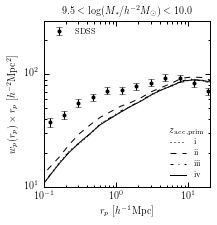

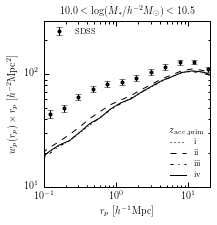

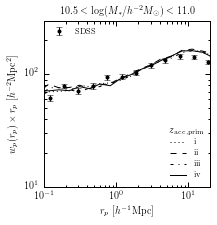

In [41]:
#compare effect of sub-halo profiles in single panel

#load SDSS results from Yang 2012
from lss_observations import yang_2012_wp

#create arrays to store results

wp_sdss_1, cov = yang_2012_wp(10.0**9.5,10.0**10.0, sample='Mass-limit')
err_1 = np.sqrt(np.diagonal(cov))

wp_sdss_2, cov = yang_2012_wp(10.0**10.0,10.0**10.5, sample='Mass-limit')
err_2 = np.sqrt(np.diagonal(cov))

wp_sdss_3, cov = yang_2012_wp(10.0**10.5,10.0**11.0, sample='Mass-limit')
err_3 = np.sqrt(np.diagonal(cov))

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p) \times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$9.5<\log(M_{*}/h^{-2}M_{\odot})<10.0$')
p3a, = ax.plot(rp_bin_centers, wp_3a[0]*rp_bin_centers, ':', color='black', alpha=1)
p3b, = ax.plot(rp_bin_centers, wp_3b[0]*rp_bin_centers, '--', color='black', alpha=1)
p3c, = ax.plot(rp_bin_centers, wp_3c[0]*rp_bin_centers, '-.', color='black', alpha=1.0)
p3d, = ax.plot(rp_bin_centers, wp_3d[0]*rp_bin_centers, '-', color='black', alpha=1.0)
p0 = ax.errorbar(wp_sdss_1[0,:], wp_sdss_1[1,:]*wp_sdss_1[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')
upper_legend = plt.legend([p0], [r'$\rm SDSS$'], frameon = False, fontsize=8, loc='upper left', numpoints=1, handletextpad=1)
ax.legend((p3a,p3b,p3c,p3d),('i','ii','iii','iv'), title=r'$z_{\rm acc, prim}$',
          frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)
plt.gca().add_artist(upper_legend)
plt.show()

filepath = './plots/'
filename = 'wp_comparison_zacc_prime_1'
fig.savefig(filepath+filename+'.pdf', dpi=300)

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p) \times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.0<\log(M_{*}/h^{-2}M_{\odot})<10.5$')
p3a, = ax.plot(rp_bin_centers, wp_3a[1]*rp_bin_centers, ':', color='black', alpha=1)
p3b, = ax.plot(rp_bin_centers, wp_3b[1]*rp_bin_centers, '--', color='black', alpha=1)
p3c, = ax.plot(rp_bin_centers, wp_3c[1]*rp_bin_centers, '-.', color='black', alpha=1.0)
p3d, = ax.plot(rp_bin_centers, wp_3d[1]*rp_bin_centers, '-', color='black', alpha=1.0)
p0 = ax.errorbar(wp_sdss_2[0,:], wp_sdss_2[1,:]*wp_sdss_2[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')
upper_legend = plt.legend([p0], [r'$\rm SDSS$'], frameon = False, fontsize=8, loc='upper left', numpoints=1, handletextpad=1)
ax.legend((p3a,p3b,p3c,p3d),('i','ii','iii', 'iv'), title=r'$z_{\rm acc, prim}$',
          frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)
plt.gca().add_artist(upper_legend)
plt.show()

filepath = './plots/'
filename = 'wp_comparison_zacc_prime_2'
fig.savefig(filepath+filename+'.pdf', dpi=300)


fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.set_xlim([0.1,20])
ax.set_ylim([10,300])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$w_p(r_p) \times r_p ~ [h^{-2}{\rm Mpc}^2]$')
ax.set_xlabel(r'$r_p~[h^{-1}{\rm Mpc}]$')
ax.set_title(r'$10.5<\log(M_{*}/h^{-2}M_{\odot})<11.0$')
p3a, = ax.plot(rp_bin_centers, wp_3a[2]*rp_bin_centers, ':', color='black', alpha=1)
p3b, = ax.plot(rp_bin_centers, wp_3b[2]*rp_bin_centers, '--', color='black', alpha=1)
p3c, = ax.plot(rp_bin_centers, wp_3c[2]*rp_bin_centers, '-.', color='black', alpha=1.0)
p3d, = ax.plot(rp_bin_centers, wp_3d[2]*rp_bin_centers, '-', color='black', alpha=1.0)
p0 = ax.errorbar(wp_sdss_3[0,:], wp_sdss_3[1,:]*wp_sdss_3[0,:], yerr=err_1*wp_sdss_1[0,:],
                  fmt='o', color='black', ms=4, mec='none')
upper_legend = plt.legend([p0], [r'$\rm SDSS$'], frameon = False, fontsize=8, loc='upper left', numpoints=1, handletextpad=1)
ax.legend((p3a,p3b,p3c,p3d),('i','ii','iii', 'iv'), title=r'$z_{\rm acc, prim}$',
          frameon = False, fontsize=8, loc='lower right', numpoints=1, handletextpad=1)
plt.gca().add_artist(upper_legend)
plt.show()

filepath = './plots/'
filename = 'wp_comparison_zacc_prime_3'
fig.savefig(filepath+filename+'.pdf', dpi=300)